In [43]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
df = pd.read_csv('CMG_smooth_0.8.csv', index_col=0)
df

,Timestamp,Date,Close,Volume,Open,High,Low,Vwap,MACD Value,Signal,RSI Value,Williams %R,%K,%D,%J
0,1612846800000,2021-02-09,30.822547,1.770398e+07,30.037442,31.087737,29.974631,30.777667,0.787331,0.773687,64.305307,-23.824295,76.175705,76.175705,76.175705
1,1612933200000,2021-02-10,30.879069,1.269680e+07,30.970689,31.192267,30.398926,30.872199,0.806644,0.780279,59.027217,-25.721759,75.226973,75.701339,74.278241
2,1613019600000,2021-02-11,30.865574,9.271359e+06,30.886937,31.014933,30.590186,30.823600,0.810110,0.786245,61.169698,-26.830112,74.541278,75.314652,72.994530
3,1613106000000,2021-02-12,30.616315,7.418272e+06,30.820428,30.896747,30.470038,30.620401,0.779008,0.784797,59.131440,-47.300797,66.715777,72.161343,55.824647
4,1613451600000,2021-02-16,29.867263,1.426765e+07,30.660086,30.675350,29.717367,29.943067,0.676041,0.763046,49.018145,-89.836857,45.344078,62.200378,11.631479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,1737694800000,2025-01-24,56.810306,1.140156e+07,57.029627,57.373500,56.194083,56.790001,-1.268287,-1.195174,35.107387,-72.997336,35.490724,31.080886,44.310400
995,1737954000000,2025-01-27,58.002061,1.194175e+07,56.421926,58.258700,56.214818,57.666667,-1.108426,-1.177824,44.224417,-44.551666,55.036582,40.195781,84.718183
996,1738040400000,2025-01-28,57.864414,9.348590e+06,57.828385,58.219739,56.898963,57.703334,-1.008039,-1.143867,45.851165,-35.388224,61.073277,50.533528,82.152775
997,1738126800000,2025-01-29,58.188883,7.127318e+06,57.733676,58.491949,57.379793,58.110001,-0.882801,-1.091654,51.236744,-20.312215,74.651749,63.587202,96.780841


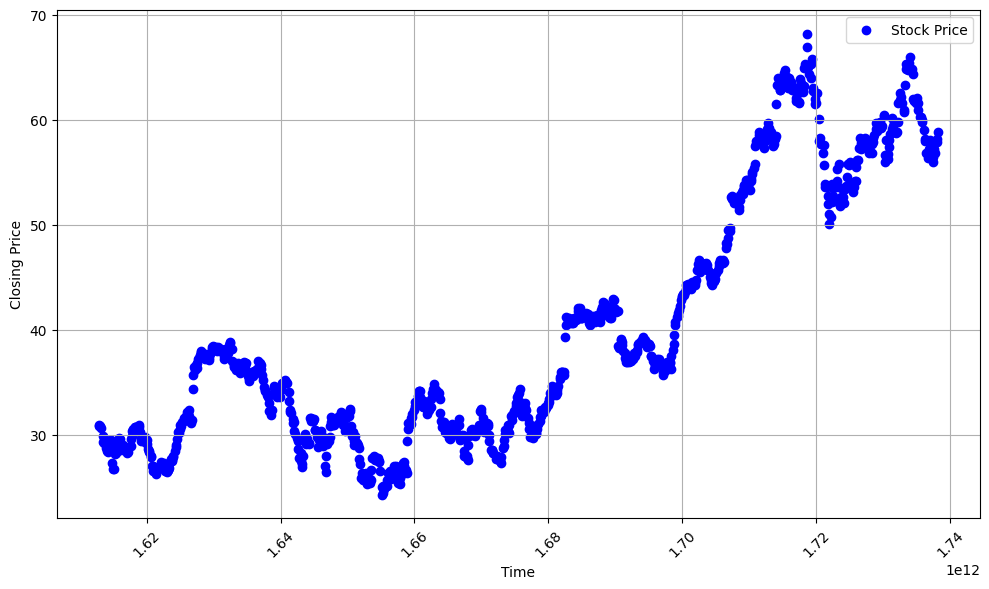

In [29]:
# Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.scatter(df['Timestamp'], df['Close'], color = 'blue', label = 'Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Put closing prices into numpy array
closing_prices = df['Close'].values.reshape(-1, 1)

# Normalize the data between [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)

# Split into training and validation sets
train_size = int(len(df) * 0.7)
val_size = len(df) - train_size

train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]

window_size = 60
X_train, y_train = create_sequences(train, window_size)
X_val, y_val = create_sequences(val, window_size)

In [31]:
model = keras.Sequential([
    layers.LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    layers.Dropout(0.2),
    layers.LSTM(50),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,017 (121.16 KB)

 Trainable params: 31,017 (121.16 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0222 - val_loss: 0.0662
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0062 - val_loss: 0.0205
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0064 - val_loss: 0.0084
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0054 - val_loss: 0.0117
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0041 - val_loss: 0.0112
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0037 - val_loss: 0.0066
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0032 - val_loss: 0.0161
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0

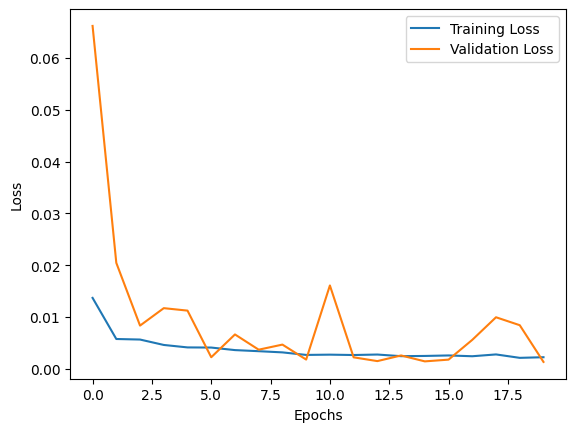

In [34]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [59]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_val)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_val])


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


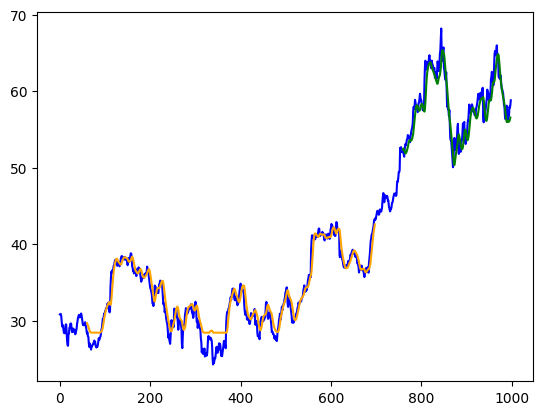

In [58]:
trainPredictPlot = np.empty_like(closing_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size :len(trainPredict) + window_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(closing_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (window_size * 2) + 1 : len(closing_prices)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled_data), color = 'blue')
plt.plot(trainPredictPlot, color = 'orange')
plt.plot(testPredictPlot, color = 'green')
plt.show()